In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1602681254081_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   64862472  2017-08-09 12:02:06   
1   132701151 2017-12-12 22:10:24   
2   133187177 2017-12-14 17:59:08   
3   138106475 2018-01-28 07:01:48   
4   231851835 2019-03-05 06:44:08   
..        ...                 ...   
95  231933956 2019-03-06 09:05:03   
96  231935796 2019-03-06 10:17:57   
97  231936247 2019-03-06 10:26:53   
98  231937856 2019-03-06 10:52:37   
99  231969621 2019-03-06 15:12:48   

                                                 REVIEW_HEADLINE  \
0   Avoid buying anything from this guy                            
1   Ugg or UGH!!                                                   
2   Not used it yet but seems excellent value for the money.       
3   Disappointed                                                   
4   For some reason, I couldn't purchase this using the app a...   
..                                                           ...   
95  Received inoperable waiting for replacement                    
96  Bought 

In [35]:
query_testing_2 = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' \
limit 500000"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             500000 non-null  int64         
 1   CREATED_DATE       500000 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    499985 non-null  object        
 3   REVIEW_COMMENTS    499996 non-null  object        
 4   REVIEW_RATING      499999 non-null  float64       
 5   REVIEWER_NICKNAME  499997 non-null  object        
 6   REVIEWER_LOCATION  499997 non-null  object        
 7   OBSERVATIONS       500000 non-null  object        
 8   PM                 500000 non-null  int64         
 9   NR                 500000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 38.1+ MB

In [37]:
reviews_2['NR'].sum(axis=0)
#reviews_2[reviews_2['NR']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [38]:
reviews = pd.concat([reviews, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  \
0       64862472  2017-08-09 12:02:06   
1       132701151 2017-12-12 22:10:24   
2       133187177 2017-12-14 17:59:08   
3       138106475 2018-01-28 07:01:48   
4       231851835 2019-03-05 06:44:08   
...           ...                 ...   
499995  236774953 2019-04-23 19:01:32   
499996  236782875 2019-04-24 02:28:00   
499997  249926618 2019-01-18 16:00:00   
499998  231849281 2019-02-21 20:01:54   
499999  231850095 2019-02-22 15:41:47   

                                                     REVIEW_HEADLINE  \
0       Avoid buying anything from this guy                            
1       Ugg or UGH!!                                                   
2       Not used it yet but seems excellent value for the money.       
3       Disappointed                                                   
4       For some reason, I couldn't purchase this using the app a...   
...                                                              ...   
499

In [39]:
#reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))

#df.loc[df['set_of_numbers'] <= 4, 'equal_or_lower_than_4?'] = 'True' 
#reviews.loc[reviews['NOLABEL'] == 0, 'TEST'] = 1
#df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        float64       
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
dtype: object

In [45]:
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] 
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   64862472  2017-08-09 12:02:06   
1   132701151 2017-12-12 22:10:24   
2   133187177 2017-12-14 17:59:08   
3   138106475 2018-01-28 07:01:48   
4   231851835 2019-03-05 06:44:08   
..        ...                 ...   
95  231933956 2019-03-06 09:05:03   
96  231935796 2019-03-06 10:17:57   
97  231936247 2019-03-06 10:26:53   
98  231937856 2019-03-06 10:52:37   
99  231969621 2019-03-06 15:12:48   

                                                 REVIEW_HEADLINE  \
0   Avoid buying anything from this guy                            
1   Ugg or UGH!!                                                   
2   Not used it yet but seems excellent value for the money.       
3   Disappointed                                                   
4   For some reason, I couldn't purchase this using the app a...   
..                                                           ...   
95  Received inoperable waiting for replacement                    
96  Bought 

In [46]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        float64       
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
ALL_TEXT             object        
dtype: object

In [47]:


#reviews['PRICE'] = bool(re.match('location', str(reviews['ALL_TEXT'])))
#reviews[reviews['PRICE']==True].head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  \
0       64862472  2017-08-09 12:02:06   
1       132701151 2017-12-12 22:10:24   
2       133187177 2017-12-14 17:59:08   
3       138106475 2018-01-28 07:01:48   
4       231851835 2019-03-05 06:44:08   
...           ...                 ...   
499995  236774953 2019-04-23 19:01:32   
499996  236782875 2019-04-24 02:28:00   
499997  249926618 2019-01-18 16:00:00   
499998  231849281 2019-02-21 20:01:54   
499999  231850095 2019-02-22 15:41:47   

                                                     REVIEW_HEADLINE  \
0       Avoid buying anything from this guy                            
1       Ugg or UGH!!                                                   
2       Not used it yet but seems excellent value for the money.       
3       Disappointed                                                   
4       For some reason, I couldn't purchase this using the app a...   
...                                                              ...   
499

In [49]:
nlp = spacy.load("en_core_web_lg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
#Some NaN values causing an error when applying word embedding vector
#reviews['ALL_TEXT'].isnull().values.any()

#Remove NaN values
reviews.dropna(inplace=True)
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010106 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   UGC_ID             1010106 non-null  int64         
 1   CREATED_DATE       1010106 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    1010106 non-null  object        
 3   REVIEW_COMMENTS    1010106 non-null  object        
 4   REVIEW_RATING      1010106 non-null  float64       
 5   REVIEWER_NICKNAME  1010106 non-null  object        
 6   REVIEWER_LOCATION  1010106 non-null  object        
 7   OBSERVATIONS       1010106 non-null  object        
 8   PM                 1010106 non-null  int64         
 9   NR                 1010106 non-null  int64         
 10  ALL_TEXT           1010106 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 92.5+ MB

In [52]:
reviews['ALL_TEXT'].isnull().values.any()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

False

In [53]:
#1 million rows can't be processed in 1 hr before auto shutdown
#Try with 100k rows - still not working
#Try with 10k rows
from random import sample 
reviews = reviews.sample(n=100000, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 444151 to 252510
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             100000 non-null  int64         
 1   CREATED_DATE       100000 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    100000 non-null  object        
 3   REVIEW_COMMENTS    100000 non-null  object        
 4   REVIEW_RATING      100000 non-null  float64       
 5   REVIEWER_NICKNAME  100000 non-null  object        
 6   REVIEWER_LOCATION  100000 non-null  object        
 7   OBSERVATIONS       100000 non-null  object        
 8   PM                 100000 non-null  int64         
 9   NR                 100000 non-null  int64         
 10  ALL_TEXT           100000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 9.2+ MB

In [55]:
#100k started at 1114, 1135 done

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
reviews['vec'] = reviews['ALL_TEXT'].apply(lambda x: get_vec(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
reviews['vec'].shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(100000,)

In [58]:
X_text = reviews['vec'].to_numpy().reshape(-1,1)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(100000, 1)

In [59]:
X_text = np.concatenate(np.concatenate(X_text, axis =0), axis = 0).reshape(-1, 300)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(100000, 300)

In [60]:
ratings = (reviews['REVIEW_RATING']/5).to_numpy().reshape(-1,1)
ratings.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(100000, 1)

In [61]:
X = np.hstack([X_text, ratings])
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[-0.05894032,  0.18462455, -0.15828973, ..., -0.01913641,
         0.25470573,  0.8       ],
       [-0.0096678 ,  0.19109771, -0.18375407, ...,  0.05515682,
         0.12509842,  0.2       ],
       [-0.10746013,  0.2989772 , -0.16368522, ...,  0.09712423,
         0.05797277,  0.2       ],
       ...,
       [ 0.01950005,  0.17532666, -0.14099529, ...,  0.11942743,
         0.16885583,  1.        ],
       [-0.01316363,  0.17977811, -0.16668838, ...,  0.0338438 ,
         0.11367346,  1.        ],
       [ 0.01683284,  0.16463485, -0.10324879, ...,  0.01004175,
         0.10007915,  0.4       ]])

In [62]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        NR
444151  1 
407081  1 
362330  1 
70165   1 
226004  1 
...    .. 
381215  1 
80315   1 
352062  0 
246784  1 
252510  1 

[100000 rows x 1 columns]

In [63]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    50733
dtype: int64

In [64]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[-0.031269    0.15710847 -0.23862714 ...  0.08680209  0.0975458
   0.8       ]
 [-0.01997307  0.1689449  -0.15493745 ... -0.00644278  0.14507808
   1.        ]
 [-0.04519614  0.16714716 -0.26348019 ...  0.09864762  0.13623945
   0.2       ]
 ...
 [-0.08618928  0.19401088 -0.20129769 ...  0.03017056  0.18468466
   1.        ]
 [-0.39066499  0.28947851  0.039635   ...  0.43541998  0.37668499
   0.8       ]
 [-0.12352309  0.26982671 -0.11783699 ... -0.04073102  0.10355505
   0.8       ]]

In [66]:
print(ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        NR
29962   0 
496068  0 
485146  0 
283615  0 
44987   1 
...    .. 
289870  0 
33238   1 
457239  0 
271850  1 
11795   0 

[80000 rows x 1 columns]

In [67]:
#nlp = spacy.load("en_core_web_lg")
#tokens = nlp("dog cat banana afskfsd eyebrow lipliner 13")

#for token in tokens:
#    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.vector)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = OneVsRestClassifier(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
#UserWarning: Label not 17 is present in all training examples.
#Due to fact that 'US' does not appear in training set (is all 0s) 
#RESOLVES AS DATA SIZE INCREASES

#Getting max iteration exceeded error
#All TF-IDF features are range 0-1, scaled rating to be divided by 5 so that is also range 0-1
#Lower max_features for TF-IDF to reduce dimensionality


clf.fit(xtrain, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [70]:
#ytrain.dtypes
#NO US LABEL
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    40586
dtype: int64

In [71]:
y_pred = clf.predict(xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
%matplotlib inline

In [74]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

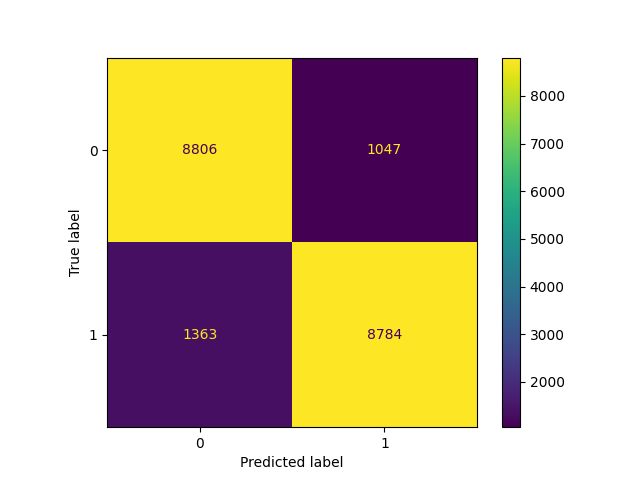

In [75]:
%matplot plt

In [76]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8795
Precision is:  0.893500152578578
Recall is:  0.8656745836207747
F1 Score is:  0.8793673040344379

In [78]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      9853
           1       0.89      0.87      0.88     10147

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

In [79]:
probs = clf.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9470499230178648

In [80]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

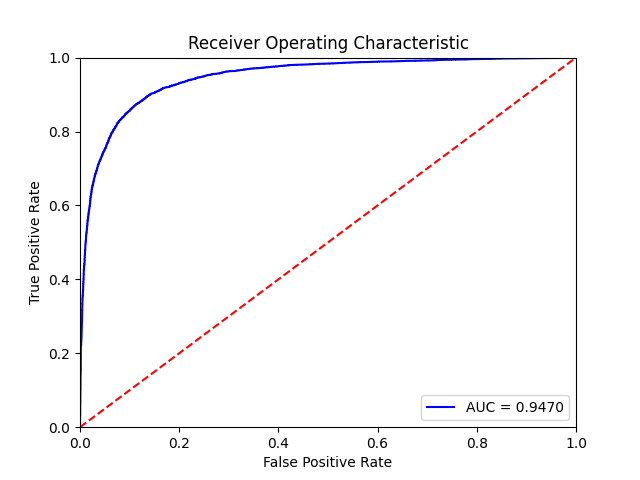

In [82]:
%matplot plt

In [83]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.47939322384028366
Optimal tpr value: 0.8721789691534444
Optimal fpr value: 0.11164112453059982

In [84]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.88015
Precision is:  0.8894472361809045
Recall is:  0.8721789691534444
F1 Score is:  0.8807284669353636

In [86]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20000

In [87]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
auc = auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

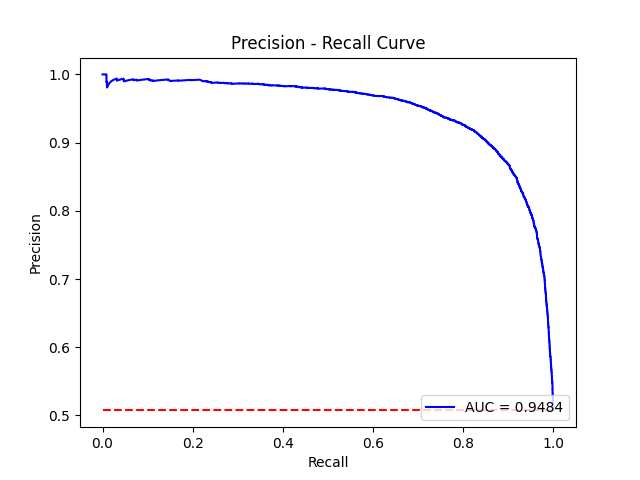

In [90]:
%matplot plt

In [91]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.388431, F-Score=0.884
Recall=0.902730
Precision=0.866276

In [92]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

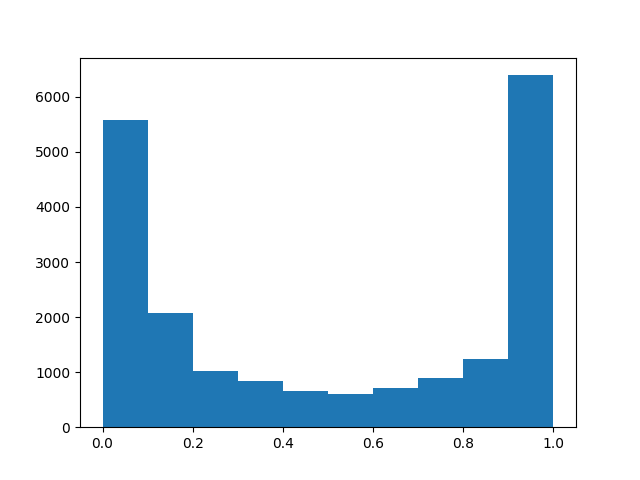

In [94]:
%matplot plt

In [95]:
#LOGISTIC REGRESSION

#Single tokens
#data set = 500,000
#max_features = 30000
#Best Threshold=0.209417, F-Score=0.498
#Recall 0.49516908212560384
#Precision 0.5012224938875306


#Single tokens
#data set = 500,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#Single tokens
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#2 n-grams
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.221356, F-Score=0.484
#Recall=0.471806
#Precision=0.495870

#3 n-grams
#data set = 5,000,000
#max_features = 50000 or 30000
#BOTH MAX FEATURE SIZES GIVE MEMORY ERROR

#Word embeddings
#data set = 500,000
#Best Threshold=0.228202, F-Score=0.471
#Recall=0.454545
#Precision=0.488506

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…